In [ ]:
!pip install pennylane


#install JAX
%pip install --upgrade pip setuptools wheel
%pip install --upgrade "jax[cpu]" optax flax


In [25]:
import pennylane as qml
import numpy as np


import jax
import jax.numpy as jnp
import optax                 #standard optimization library for JAX


import random
import time
import matplotlib.pyplot as plt

random.seed(10)


In the context of quantum variational algorithm, we focus on the gate $R_G$ generated by fixed operators $G \in \mathcal{G}$ where $\mathcal{G}$ are the fixed gatesets,

\begin{equation*} 
R_G(\theta) = exp(-i \theta G)
\end{equation*}\\

\
The symmetry group $\mathcal{S}$ is embodied by the unitary representation $U_s$ for $s \in \mathcal{S}$. And a gate is equivarant with respect to the symmetry if 

\begin{equation*} 
[R_G(\theta), U_s] = 0,\ \ \  \forall \theta \in \mathbb{R},\ \  \forall s \in \mathcal{S}
\end{equation*}\\

\
Futhermore, for a given gate $R_G$,
\begin{equation*} 
[R_G(\theta), U_s] = 0\ \ \  \Longleftrightarrow \ \ \ [G, U_s] = 0
\end{equation*}\\

We call a data encoding unitary $U(x)$ equivariant with respect to the data symmetry $V_s$ if the unitary lives in the adjont representation of $U_s$, i.e.

\begin{equation*} 
U(V_s [x]) = U_s U(x) U^\dagger _s
\end{equation*}\\


Twirling formula gives us the operators equivariant with respect to the summetry group ($S$).

\begin{equation*} 
\begin{split}
\mathcal{T}_U[x] &= \frac{1}{|s|} \sum_{s\in S}U_s X U^{\dagger}_s \\
&= \int d\mu (s) U_s X U^{\dagger}_s
\end{split}
\end{equation*}\\

$\Rightarrow [\mathcal{T}_U[x], U_s] = 0,\ \ \  \forall x$ and $\forall s \in S$.




Prepare the board

In [26]:
# Extract game logic from notebook
def create_board():
    return np.zeros((3,3))

def empty_places(board):
    return list(zip(*np.where(board == 0)))


def random_play(board, player):
    """Make a random move for the player. Returns a copy to avoid mutations."""
    possible_places = empty_places(board)
    if not possible_places:
        return board
    player_selection = random.choice(possible_places)
    # Create a copy to avoid mutation issues
    new_board = board.copy()
    new_board[player_selection] = player
    return new_board


1) Set up the 3 winning conditions 

2) Check if the winning conditions are met

In [27]:
# 1) Check 3 in a row
def row_win(board, player):
    for row in board:
        if all(row == player):
            return True
    return False


# 2) Check 3 in a column
def column_win(board, player):
    for col in board.T:
        if all(col == player):
            return True
    return False


# 3) Check 3 in a diagonal
def diagonal_win(board, player):
    if all(np.diag(board) == player):
        return True
    if all(np.diag(np.fliplr(board)) == player):
        return True
    return False


# Check if one of the winning conditions is met
def evaluate_game(board):
    winner = None
    for player in [1, -1]:
        if row_win(board, player) or column_win(board, player) or diagonal_win(board, player):
            winner = player
    
    if len(empty_places(board)) == 0 and winner is None:
        winner = 0
    
    return winner


Start the game and record the results

In [28]:
# Combine all functions to play the game
def play_game():
    board = create_board()
    winner = None
    
    # Play until game ends (max 9 moves)
    for move_count in range(9):
        # Alternate players: X (1) goes first, then O (-1)
        player = 1 if move_count % 2 == 0 else -1
        
        # Check if there are empty spaces
        if len(empty_places(board)) == 0:
            break
        
        # Make move
        board = random_play(board, player)
        
        # Check for winner
        winner = evaluate_game(board)
        
        if winner is not None:
            break
    
    # If no winner found after all moves, it's a draw
    if winner is None:
        winner = 0
    
    return [np.ndarray.flatten(board), winner]


In [29]:
def create_dataset(size_of_each_winner: int, timeout_seconds=120):
    """Generate balanced dataset with timeout for rare classes.
    
    Args:
        size_of_each_winner: Target number of games for each outcome
        timeout_seconds: Maximum time to spend per class
    
    Returns:
        List of (board, winner) tuples
    """
    
    game_result = {-1: [], 0: [], 1: []}
    
    print(f"  Generating up to {size_of_each_winner * 3} games ({size_of_each_winner} per class)...")
    start_time = time.time()
    games_generated = 0
    last_update = 0
    
    # Keep generating with timeout protection
    while any(len(boards) < size_of_each_winner for boards in game_result.values()):
        # Check timeout
        if time.time() - start_time > timeout_seconds:
            print(f"\n  ⚠ Timeout after {timeout_seconds}s - using what we have")
            break
            
        board, winner = play_game()
        games_generated += 1
        
        # Only add if this class needs more samples
        if len(game_result[winner]) < size_of_each_winner:
            game_result[winner].append(board)
        
        # Progress update every 50 games
        total_collected = sum(len(boards) for boards in game_result.values())
        if games_generated - last_update >= 50:
            print(f"    Progress: {total_collected}/{size_of_each_winner * 3} games | "
                  f"O:{len(game_result[-1])}, Draw:{len(game_result[0])}, X:{len(game_result[1])} | "
                  f"Generated {games_generated} total")
            last_update = games_generated
    
    # Convert dictionary to list (use all we have, even if imbalanced)
    result = []
    for winner, boards in game_result.items():
        result += [(board, winner) for board in boards]
    
    elapsed = time.time() - start_time
    o_count = len([r for r in result if r[1] == -1])
    draw_count = len([r for r in result if r[1] == 0])
    x_count = len([r for r in result if r[1] == 1])
    
    print(f"  ✓ Dataset complete in {elapsed:.1f}s: {o_count} O-wins, "
          f"{draw_count} draws, {x_count} X-wins (Total: {len(result)})")
    
    if draw_count < size_of_each_winner * 0.8:
        print(f"  Note: Draws are rare. Got {draw_count}/{size_of_each_winner} - this is normal!")
    
    return result


<img src="graphics/indexing.png" width="300" />

This is the indexing scheme of our tic-tac-toe game. We are assigning 1 qubit for each index, so we will be working with 9 qubits in total. 

This board resembles a $D_4$ group, if we denote the generators of the $D_4$ group by $a,b$ where $a$ generates $\frac{\pi}{2}$ anti-clockwise rotation and $b$ generates a filp or reflection around the vertical axis through the center. Then we can denote the 8 elements of the $D_4$ group as $\{\mathbb{1},a,a^2,a^3,ab,a^2b,a^3b\}$.

<img src="graphics/D4_symmetry.png" width="300" />

Above figure shows the actions of the 8 generators of $D_4$ group on our game. 


Next, we would like to express these 8 generators in the context of quantum circuit and quantum gates. First, we utilize the fact that the $D_4$ or dihedral groups in are general a subgroup of permutation group $S_n$. Follwoing our indexing scheme, the 8 elements of the $D_4$ group are expressed as the following permutations,

\begin{equation*}
\begin{split}
\mathbf{1}\ \ \ &\to \mathbf{1}\\
a\ \ \ &\to (0286)(1573)\\
a^2\ \ \ &\to (08)(26)(17)(35)\\
a^3\ \ \ &\to (0682)(1357)\\
b\ \ \ &\to (26)\\
ab\ \ \ &\to (02)(35)(68)\\
a^2b\ \ \ &\to (08)\\
a^3b\ \ \ &\to (06)(17)(28).
\end{split}
\end{equation*}

The permutations of $D_4$ group show us 3 observations on the vertices (if we treat each position on our board as one vertex):
1) The center of the board (4) is not involved in any actions.

2) The corners (0,2,6,8) permute together as a goup

3) The edges (1,3,5,7) permute together as a goup

These observations motivate us to group the 9 postions of our board into 3 equivalence classes of invariant observable $(O)$. 

\begin{equation*}
\begin{split}
O_{middle} &= Z_4\\
O_{corners} &= \frac{1}{4}[Z_0+Z_2+Z_6+Z_8] \\
O_{edges} &= \frac{1}{4}[Z_1+Z_3+Z_5+Z_7], 
\end{split}
\end{equation*}\\
where $Z_i,\ i \in (1,9)$ are the expectation value of the 9 positions of our board. Therefore, the qubits living in the same equivalence class should undergo the same symmetry operation. In other word, a single-qubit gate has to act on the qubits in the same equivalence class equally. 

We choose the single-qubit gate acting on each vertex to be 
\begin{equation*}
R_Y(\theta_2)R_X(\theta_1).
\end{equation*}\\
Then, generalizing into our board, if $D_4$ symmetry is not considered, we would need 18 parameters since two parameters are needed for each of the 9 vertices.
On the other hand, if $D_4$ symmetry is considered, only 6 parameters are needed since we need two parameters for each of the 3 equivalence classes.

<img src="graphics/single_qubit_gate.png" width="300" />

The image summerize the 3 equivalence classes with the yellow box representing the middle class, the green boxes representing the corners class and the red boxes representing the edges class.


Next, we are going to investigate the $D_4$ group on the edge level (the edge connecting two boxes). To do this, we study the effect of $D_4$ permutation again, focuing on the actions involving $b$ this time,

\begin{equation*}
\begin{split}
b\ \ \ &\to (26)\\
ab\ \ \ &\to (02)(35)(68)\\
a^2b\ \ \ &\to (08)\\
a^3b\ \ \ &\to (06)(17)(28).
\end{split}
\end{equation*}\\

The above permutaion only presents the final result of the vertices after the action, but if we consider the edges as well, the permutation can be rewritten as the following,

\begin{equation*}
\begin{split}
b\ \ \ \ \to \ \ \ \ \ \ \ \ \ \ \ \ \ \ (26) &\to (24)(46)\\
ab\ \ \ \to (02)(35)(68) &\to (01)(12)\ (34)(45)\ (67)(78) \\
a^2b\ \ \ \to \ \ \ \ \ \ \ \ \ \ \ \ \ \  (08) &\to (04)(48)\\
a^3b\ \ \ \to (06)(17)(28) &\to (03)(36)\ (14)(47)\ (25)(58).
\end{split}
\end{equation*}\\

Then, we observe all these edges into the 3 equivalence classes again, namely

1) Edges between middle and corners: $(42)(46)(40)(48)$

2) Edges between edges and middle : $(14)(74)(34)(54)$

3) Edges between corners and edges : $(01)(21)(67)(87)(03)(63)(25)(85)$


The following image visulize the 3 equvalence classes with the yellow edges represening the $1.$ class, the red edges represening the $2.$ class and the green edges represening the $3.$ class. 

<img src="graphics/two_qubit_gates.png" width="300" />

We choose the entangling gate acting on these edges to be 
\begin{equation*}
CR_Y(\theta).
\end{equation*}\\

Therefore, without considering symmetry, we need 16 parameters to represent the rotations of the edges. While with $D_4$ symmetry, we need 3 parameters, one for each equivalence classes. 

All in all, $D_4$ symmetry reduced the number of parameter from $34 (18+16)$ to $9 (6+3)$.

Circuit without considering symmetry, 34 parameters are needed.

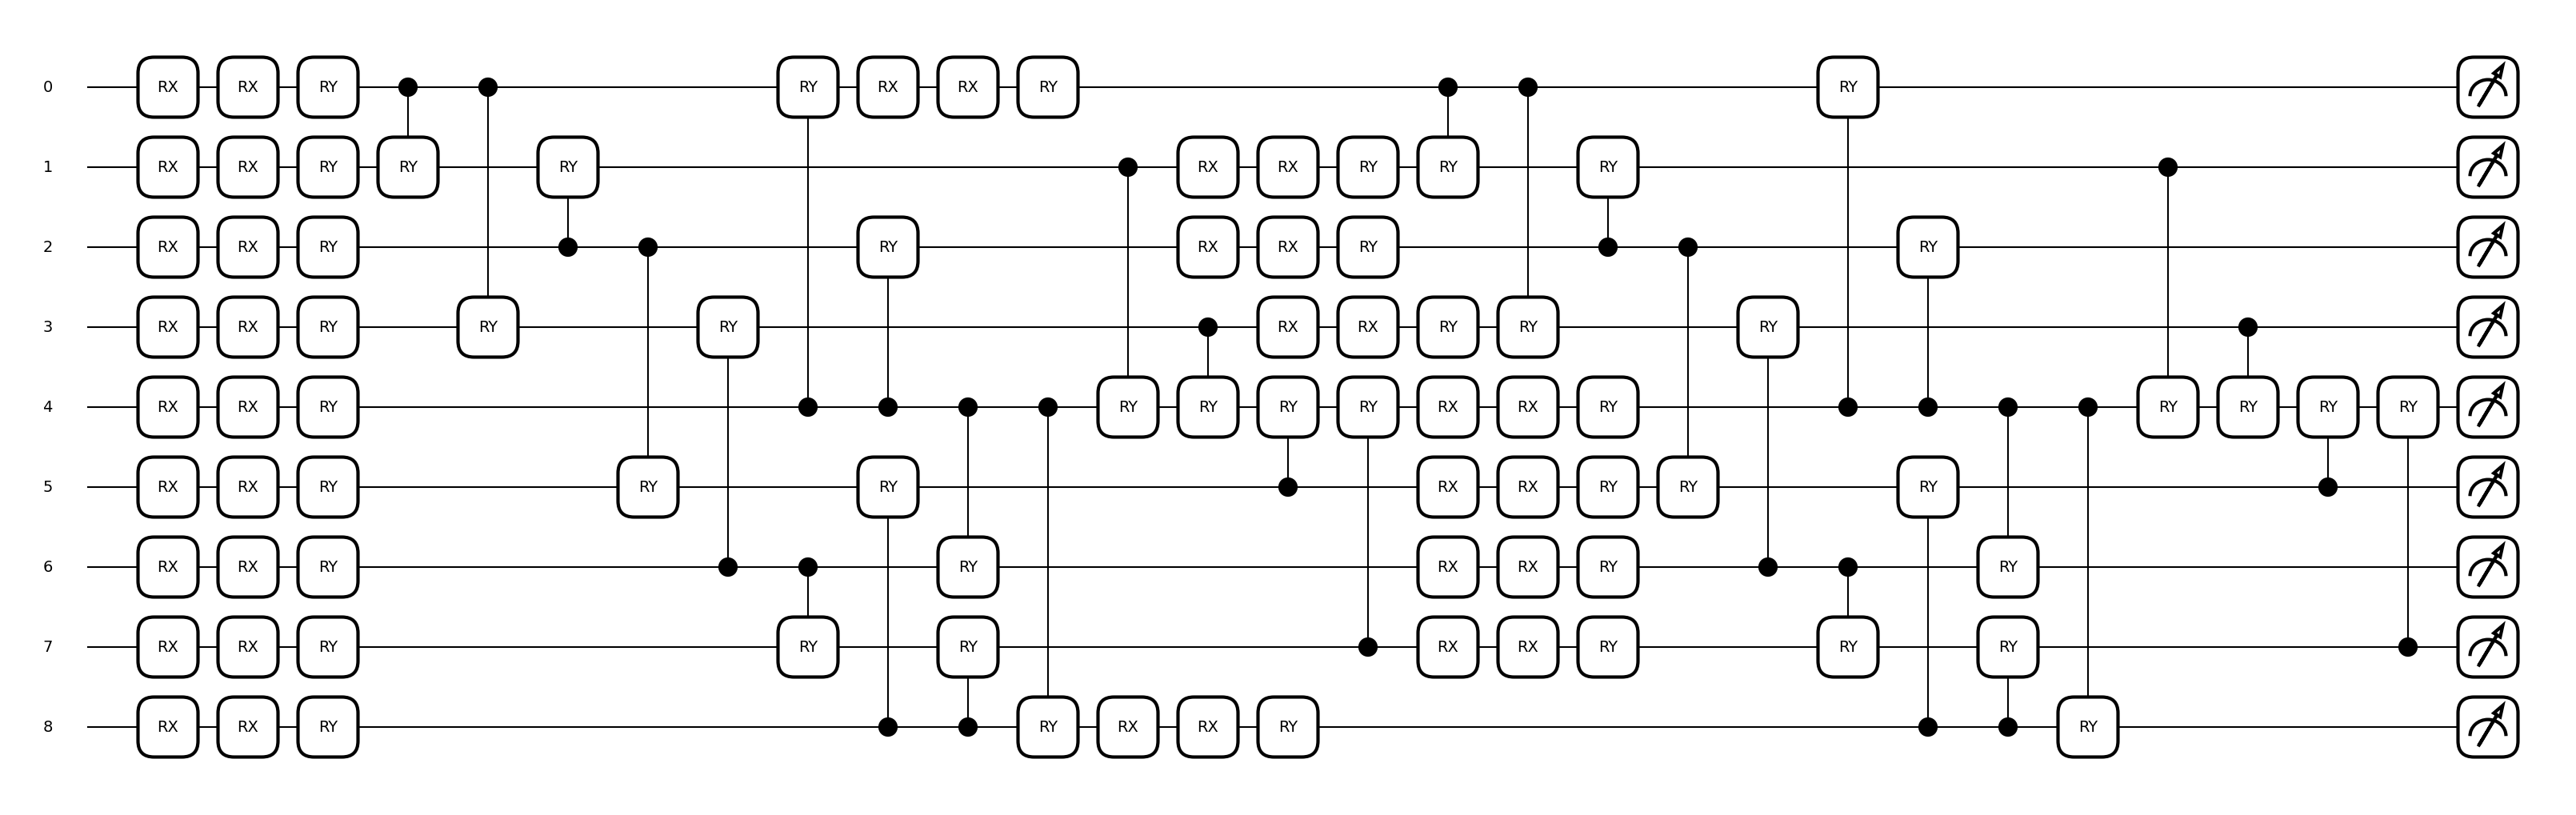

In [30]:
dev = qml.device('default.qubit', wires=9)

PARAMS_PER_LAYER_SYMM = 9  # 6 single-qubit + 3 two-qubit

@qml.qnode(dev, interface='jax')
def circuit_with_symm_multilayer(x, p, n_layers=2):
    """Equivariant circuit matching Meyer et al. (2023) Fig. 3 / 'cemoid' layout."""

    for layer in range(n_layers):
        # Data re-uploading at EVERY layer (paper: "each layer = data encoding + parametrized gates")
        for i in range(9):
            qml.RX(x[i], wires=i)

        lp = p[layer * PARAMS_PER_LAYER_SYMM : (layer + 1) * PARAMS_PER_LAYER_SYMM]

        # ── Single-qubit gates: RX + RY per equivalence class ──

        # Center (qubit 4)
        qml.RX(lp[0], wires=4)
        qml.RY(lp[1], wires=4)

        # Corners (shared)
        for i in [0, 2, 6, 8]:
            qml.RX(lp[2], wires=i)
            qml.RY(lp[3], wires=i)

        # Edges (shared)
        for i in [1, 3, 5, 7]:
            qml.RX(lp[4], wires=i)
            qml.RY(lp[5], wires=i)

        # ── Two-qubit CRY gates: 3 edge equivalence classes ──

        # Class 1: Corners ↔ Edges ring (each corner → both adjacent edges)
        for corner, adj_edges in [(0,[1,3]), (2,[1,5]), (6,[3,7]), (8,[5,7])]:
            for e in adj_edges:
                qml.CRY(lp[6], wires=[corner, e])

        # Class 2: Center → Corners
        for c in [0, 2, 6, 8]:
            qml.CRY(lp[7], wires=[4, c])

        # Class 3: Edges → Center
        for e in [1, 3, 5, 7]:
            qml.CRY(lp[8], wires=[e, 4])

    return [qml.expval(qml.PauliZ(i)) for i in range(9)]

# Visualize the circuit
fig, ax = qml.draw_mpl(circuit_with_symm_multilayer)([0]*9, [0]*18)


In [31]:
def aggregate_observables(result):
    """Aggregate raw circuit observables into invariant predictions.
    
    Returns [corners, center, edges] based on D4 symmetry grouping.
    """
    center = result[4]
    corners = (result[0] + result[6] + result[8] + result[2]) / 4
    edges = (result[1] + result[3] + result[7] + result[5]) / 4
    return jnp.array([corners, center, edges])


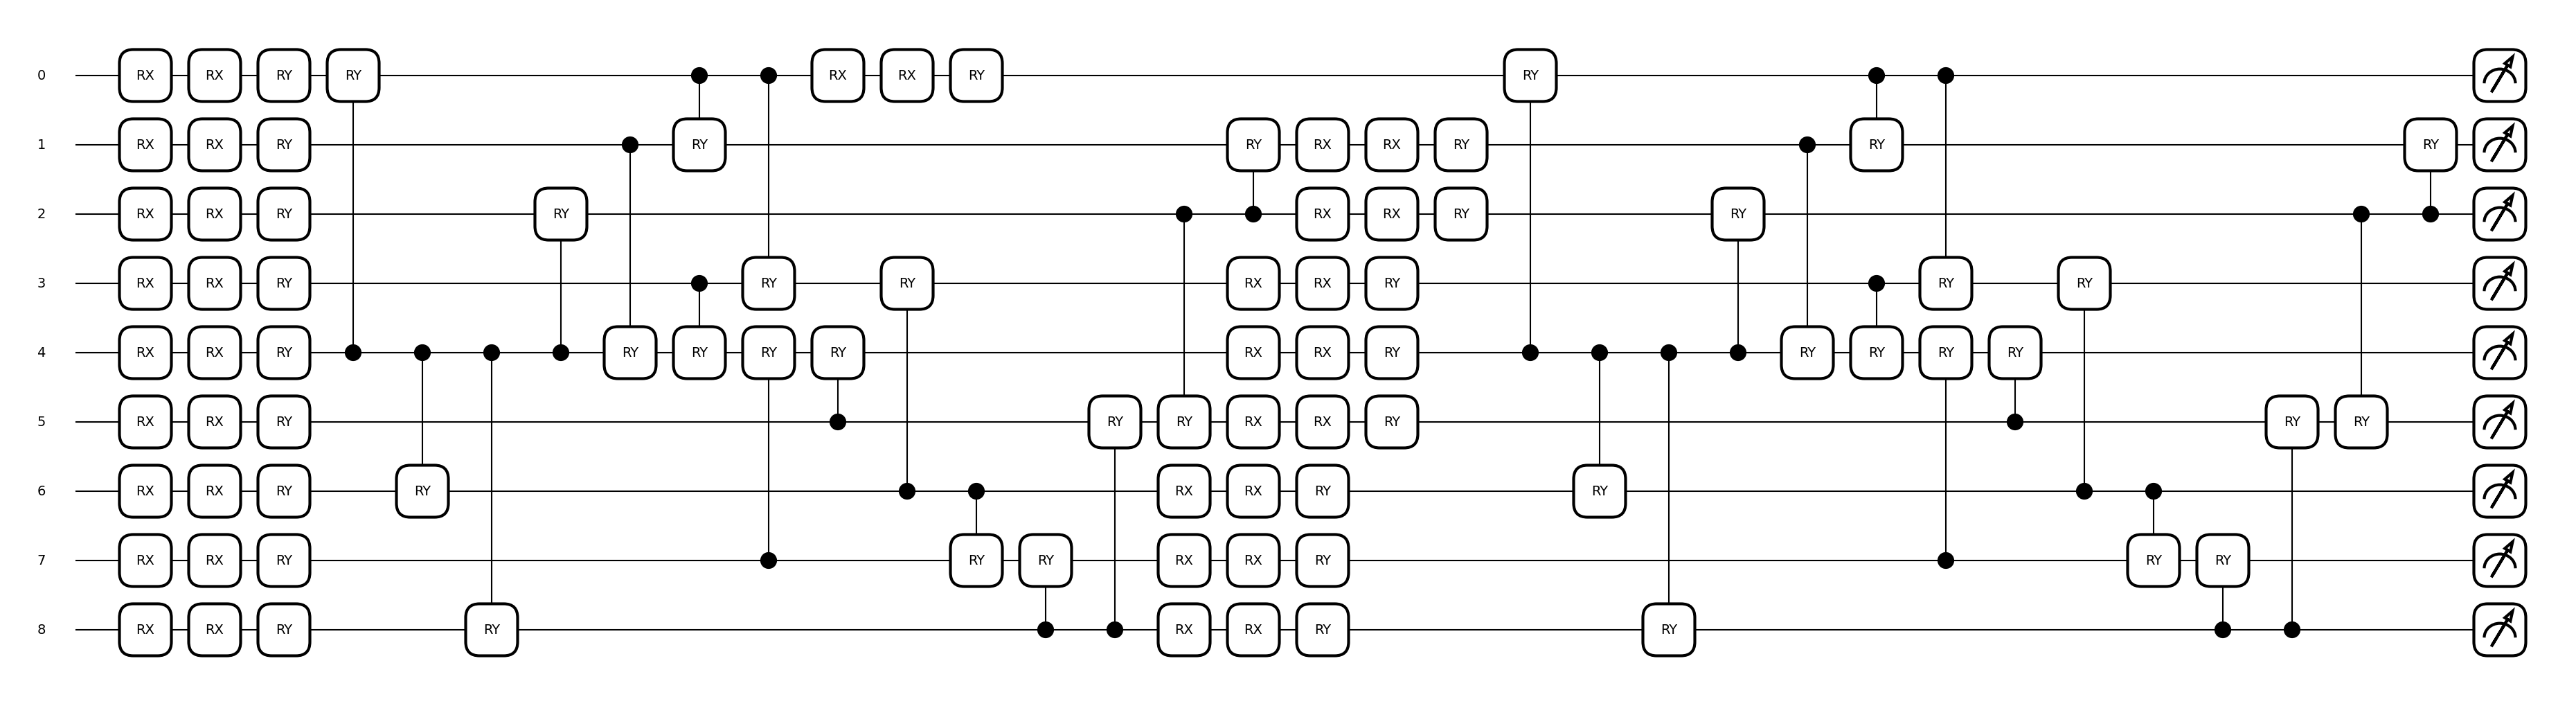

In [32]:
corner_qubits = [0,6,8,2]
edge_qubits = [1,3,7,5]
n_corners = len(corner_qubits)

PARAMS_PER_LAYER_NOSYMM = 34  # 18 single-qubit + 16 two-qubit

@qml.qnode(dev, interface='jax')
def circuit_without_symm(x, p, n_layers=2):
    for layer in range(n_layers):
        for i in range(9):
            qml.RX(x[i], wires=i)

        lp = p[layer * PARAMS_PER_LAYER_NOSYMM : (layer + 1) * PARAMS_PER_LAYER_NOSYMM]


        ################### One-qubit gates  #############################

        # Centre single qubit rotation
        qml.RX(lp[0], wires= 4)
        qml.RY(lp[1], wires= 4)

        # Corner single qubit rotation
        for i,j in zip(corner_qubits, range(2,2+n_corners)):
            qml.RX(lp[j], wires = i)

        for i,j in zip(corner_qubits, range(2+n_corners,2+2*n_corners)):
            qml.RY(lp[j], wires = i)

        # Edge single qubit rotation
        for i,j in zip(edge_qubits, range(2+2*n_corners,2+3*n_corners)):
            qml.RX(lp[j], wires = i)

        for i,j in zip(edge_qubits, range(2+3*n_corners,2+4*n_corners)):
            qml.RY(lp[j], wires = i)

        ####################### Two-qubits gates #######################

        # Edges between middle and corners rotation
        for i,j in zip(corner_qubits, range(2+4*n_corners,2+5*n_corners)):
            qml.CRY(lp[j], wires = [4,i])


        # Edges between edges and middle rotation
        for i,j in zip(edge_qubits, range(2+5*n_corners,2+6*n_corners)):
            qml.CRY(lp[j], wires = [i,4])


        # Edges between corners and edges rotation
        for index, corner in enumerate(corner_qubits):
            if index != 3:
                qml.CRY(lp[2+6*n_corners+2*index], [corner,edge_qubits[index]])
                qml.CRY(lp[2+6*n_corners+2*index+1],[corner,edge_qubits[index+1]])

            else:
                qml.CRY(lp[32],[corner,edge_qubits[-1]])
                qml.CRY(lp[33],[corner,edge_qubits[0]])


    return [qml.expval(qml.PauliZ(i)) for i in range(9)]

fig, ax = qml.draw_mpl(circuit_without_symm)([0]*9,[0]*68)


We have to encode our tic-tac-toe game. Our indexing scheme has alreday assigned 9 qubits to each of the 9 positions on the board. Then, we map the 9 boxes of our board to $(+1,-1, 0)$ which represent a nought, a cross and an emptx box respectively. This can be done by introducing a map $\mathbb{g_i},\ \ i \in {0,8}$. The image below shows an example of the map $g$. This map $g$ is implemented by the empty_places() and random_play() functions.

<img src="graphics/game_encoding.png" width="300" />

Since we instantiate with all $\ket{0}$, the $D_4$ symmetry conditions are automatically satisfied. Therefore, we initiate the circuit with $R_x(x_i)$ where $x_i = \frac{2 \pi}{3} g_i$.

The result of the game is one-hot encoded in vector $\mathbb{y} = (y_o,y_-,y_x)$, where $y_o$ indicates nought won the game while $y_x$ represents cross has won and $y_-$ represnets a 'draw'. A $+1$ will be assigned to the correct label and $-1$ to the other two entries. For example, $(+1,-1,-1)$ represnts a game won by nought.


In [33]:
def encode_game(game):
    """Encode game result to match observable ordering.
    
    Observables: [O_corners, O_center, O_edges]
    Paper mapping: O_corners -> nought wins, O_center -> draw, O_edges -> cross wins
    """
    board, result = game
    x = board * (2 * np.pi) / 3
    
    # Match paper's convention exactly
    if result == 1:      # Nought (O) wins -> expect corners high
        y = [1., -1., -1.]
    elif result == -1:   # Cross (X) wins -> expect edges high  
        y = [-1., -1., 1.]
    else:                # Draw -> expect center high
        y = [-1., 1., -1.]
    
    return x, np.array(y)


In [34]:
# Prepare training and validation datasets matching paper
# Paper uses 450 training samples (150 per class) and 300 validation samples (100 per class)
NUM_TRAINING_PER_CLASS = 150  # 450 total training samples
NUM_VALIDATION_PER_CLASS = 100  # 300 total validation samples

print(f"Generating datasets: {NUM_TRAINING_PER_CLASS * 3} training, {NUM_VALIDATION_PER_CLASS * 3} validation")
training_dataset = create_dataset(NUM_TRAINING_PER_CLASS)
validation_dataset = create_dataset(NUM_VALIDATION_PER_CLASS)

print(f"Training dataset size: {len(training_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")


Generating datasets: 450 training, 300 validation
  Generating up to 450 games (150 per class)...
    Progress: 50/450 games | O:10, Draw:7, X:33 | Generated 50 total
    Progress: 100/450 games | O:27, Draw:10, X:63 | Generated 100 total
    Progress: 150/450 games | O:45, Draw:13, X:92 | Generated 150 total
    Progress: 200/450 games | O:56, Draw:21, X:123 | Generated 200 total
    Progress: 249/450 games | O:71, Draw:28, X:150 | Generated 250 total
    Progress: 267/450 games | O:84, Draw:33, X:150 | Generated 300 total
    Progress: 290/450 games | O:99, Draw:41, X:150 | Generated 350 total
    Progress: 310/450 games | O:112, Draw:48, X:150 | Generated 400 total
    Progress: 330/450 games | O:127, Draw:53, X:150 | Generated 450 total
    Progress: 351/450 games | O:140, Draw:61, X:150 | Generated 500 total
    Progress: 369/450 games | O:150, Draw:69, X:150 | Generated 550 total
    Progress: 374/450 games | O:150, Draw:74, X:150 | Generated 600 total
    Progress: 377/450 games

In [35]:
# Encode training set
encoded_train = list(zip(*[encode_game(g) for g in training_dataset]))
x_train = np.stack(encoded_train[0])
y_train = np.stack(encoded_train[1])

# Encode validation set
encoded_val = list(zip(*[encode_game(g) for g in validation_dataset]))
x_test = np.stack(encoded_val[0])
y_test = np.stack(encoded_val[1])

We follow the paper [1], and it suggests the following loss function,
\begin{equation*}
L(\mathcal{D}) = \frac{1}{|\mathcal{D}|} \sum_{(g,y)\in \mathcal{D}} ||\hat{y}(g) - y||^2_2.
\end{equation*}

[1] 'Exploiting symmetry in variational quantum machine learning', 2022,  arXiv:2205.06217v1

In [36]:
def compute_accuracy(weights, x_data, y_data, circuit_fn):
    """Compute classification accuracy using vmap for efficiency."""
    x_data = jnp.array(x_data)
    y_data = jnp.array(y_data)
    
    # Define single prediction logic
    def predict_single(x, w):
        result = circuit_fn(x, w)
        return aggregate_observables(result)

    # Vectorize prediction
    batched_predict = jax.vmap(predict_single, in_axes=(0, None))
    
    y_hats = batched_predict(x_data, weights)
    
    pred_classes = jnp.argmax(y_hats, axis=1)
    true_classes = jnp.argmax(y_data, axis=1)
    
    return jnp.mean(pred_classes == true_classes)


**Compare accuracy between symmetrized and unsymmetrized data**

In [37]:
def optimize_circuit(x_data, y_data, params, circuit_fn, x_val=None,  y_val=None,
                      n_epochs=100, batch_size=15):
    """Generic JAX optimization loop for any circuit.
    
    Args:
        x_data: Training input data
        y_data: Training labels
        params: Initial parameters
        circuit_fn: Circuit function (x, weights) -> raw observables
        n_epochs: Number of training epochs
        batch_size: Mini-batch size
    
    Returns:
        final_weights, history dict
    """
    x_data = jnp.array(x_data)
    y_data = jnp.array(y_data)
    weights = jnp.array(params)
    
    # Optimizer - plain Adam as used in the paper
    opt = optax.adam(learning_rate=0.01)
    opt_state = opt.init(weights)
    
    # Create predict function using aggregate_observables
    def predict_fn(w, x):
        result = circuit_fn(x, w)
        return aggregate_observables(result)
    
    # Batch predict using vmap
    batched_predict = jax.vmap(predict_fn, in_axes=(None, 0))
    
    def loss_fn(w, x, y):
        preds = batched_predict(w, x)
        return jnp.mean(jnp.sum((preds - y) ** 2, axis=1))
    
    @jax.jit
    def train_step(w, opt_state, x_batch, y_batch):
        loss, grads = jax.value_and_grad(loss_fn)(w, x_batch, y_batch)
        updates, opt_state = opt.update(grads, opt_state, w)
        w = optax.apply_updates(w, updates)
        return w, opt_state, loss

    history = {'loss': [], 'val_accuracy': [], 'train_accuracy': [], 'val_loss': []}
    n_samples = len(x_data)
    
    for epoch in range(n_epochs):
        perm = jax.random.permutation(jax.random.PRNGKey(epoch), n_samples)
        x_shuffled = x_data[perm]
        y_shuffled = y_data[perm]
        
        epoch_losses = []
        for i in range(0, n_samples, batch_size):
            x_batch = x_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            weights, opt_state, loss = train_step(weights, opt_state, x_batch, y_batch)
            epoch_losses.append(float(loss))
        
        ms_loss = np.mean(epoch_losses)
        history['loss'].append(ms_loss)
        
        # Validation stats
        try:
            val_acc = compute_accuracy(weights, x_test, y_test, circuit_fn)
            history['val_accuracy'].append(float(val_acc))
            
            val_loss = loss_fn(weights, x_test, y_test)
            history['val_loss'].append(float(val_loss))
            
            train_acc = compute_accuracy(weights, x_data, y_data, circuit_fn)
            history['train_accuracy'].append(float(train_acc))
        except Exception:
            pass
            
        if epoch % 10 == 0:
            val_acc_print = history['val_accuracy'][-1] if history['val_accuracy'] else 0.0
            print(f"Epoch {epoch}: Loss {ms_loss:.4f} Val Acc {val_acc_print:.4f}")
            
    return weights, history


Starting JAX Training (Paper Implementation)...
Epoch 0: Loss 2.7477 Val Acc 0.5267
Epoch 10: Loss 2.2516 Val Acc 0.5667
Epoch 20: Loss 2.1679 Val Acc 0.6900
Epoch 30: Loss 2.1079 Val Acc 0.7067
Epoch 40: Loss 2.0652 Val Acc 0.6867
Epoch 50: Loss 2.0298 Val Acc 0.6633
Epoch 60: Loss 2.0229 Val Acc 0.6533
Epoch 70: Loss 2.0337 Val Acc 0.6533
Epoch 80: Loss 2.0283 Val Acc 0.6367
Epoch 90: Loss 2.0251 Val Acc 0.6533


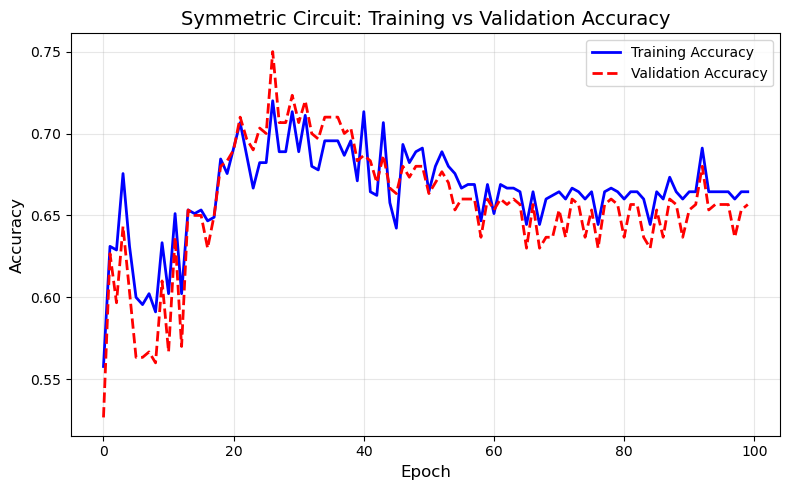


Final Training Accuracy: 0.6644
Final Validation Accuracy: 0.6567
Generalization Gap: 0.78%


In [38]:
# --- PAPER IMPLEMENTATION EXECUTION ---
print("Starting JAX Training (Paper Implementation)...")

# Initialize Params
params = 0.01 * np.random.randn(PARAMS_PER_LAYER_SYMM * 2)

# Run Training
final_weights, history = optimize_circuit(x_train, y_train, params, lambda x, w: circuit_with_symm_multilayer(x, w, n_layers=2), n_epochs=100, batch_size=15)

# Plot - Training vs Validation Accuracy
plt.figure(figsize=(8, 5))
if 'train_accuracy' in history:
    plt.plot(history['train_accuracy'], 'b-', linewidth=2, label='Training Accuracy')
if 'val_accuracy' in history:
    plt.plot(history['val_accuracy'], 'r--', linewidth=2, label='Validation Accuracy')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Symmetric Circuit: Training vs Validation Accuracy', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print final stats
if history.get('train_accuracy') and history.get('val_accuracy'):
    print(f"\nFinal Training Accuracy: {history['train_accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")
    gap = history['train_accuracy'][-1] - history['val_accuracy'][-1]
    print(f"Generalization Gap: {gap*100:.2f}%")




=== Training Non-Symmetric Circuit ===
Epoch 0: Loss 2.7866 Val Acc 0.5267
Epoch 10: Loss 2.2206 Val Acc 0.6133
Epoch 20: Loss 2.1464 Val Acc 0.5367
Epoch 30: Loss 2.1273 Val Acc 0.5367
Epoch 40: Loss 2.1165 Val Acc 0.5300
Epoch 50: Loss 2.1068 Val Acc 0.5200
Epoch 60: Loss 2.1030 Val Acc 0.5433
Epoch 70: Loss 2.0928 Val Acc 0.5633
Epoch 80: Loss 2.0944 Val Acc 0.5633
Epoch 90: Loss 2.0857 Val Acc 0.5733


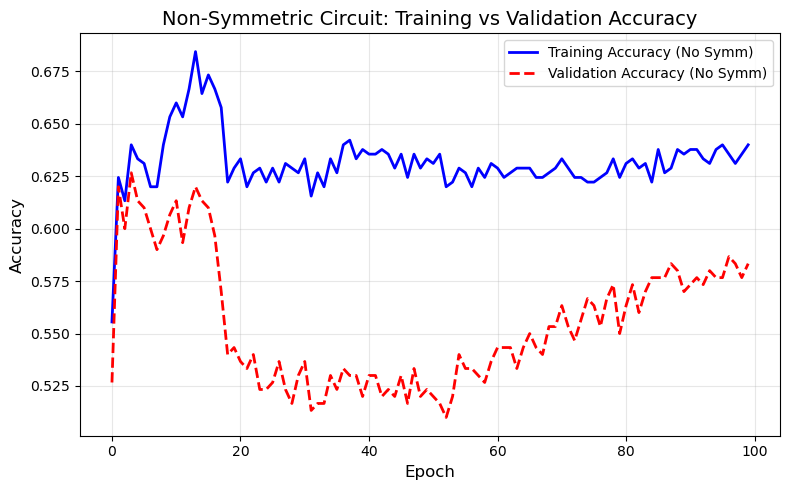


Final Training Accuracy: 0.6400
Final Validation Accuracy: 0.5833
Generalization Gap: 5.67%


=== Comparison Results ===


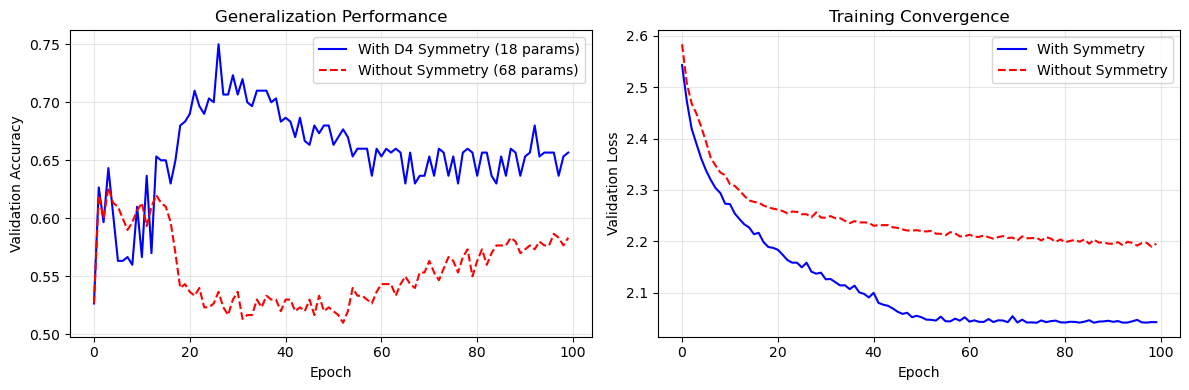

In [ ]:
def plot_comparison(history_symm, history_no_symm, history_no_circuit=None):
    """Plot validation accuracy comparison."""
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    epochs = range(len(history_symm['val_accuracy']))
    
    # Accuracy plot
    ax1.plot(epochs, history_symm['val_accuracy'], 'b-', label='With D4 Symmetry (18 params)') # Updated label to 18
    ax1.plot(epochs, history_no_symm['val_accuracy'], 'r--', label='Without Symmetry (68 params)')
    if history_no_circuit:
        ax1.plot(epochs, history_no_circuit['val_accuracy'], 'g:', label='Classical')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Validation Accuracy')
    ax1.set_title('Generalization Performance')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss plot
    # Handle missing val_loss gracefully if not yet computed
    if 'val_loss' in history_symm and 'val_loss' in history_no_symm:
        ax2.plot(epochs, history_symm['val_loss'], 'b-', label='With Symmetry')
        ax2.plot(epochs, history_no_symm['val_loss'], 'r--', label='Without Symmetry')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Validation Loss')
        ax2.set_title('Training Convergence')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'Validation Loss not available', ha='center')
    
    plt.tight_layout()
    plt.savefig('symmetry_comparison.png', dpi=150)
    plt.show()



# --- NON-SYMMETRIC CIRCUIT TRAINING FOR COMPARISON ---
print("\n\n=== Training Non-Symmetric Circuit ===")


# Initialize non-symmetric params (34 params)
params_nosymm = 0.01 * np.random.randn(68)

# Train non-symmetric model
final_weights_nosymm, history_nosymm = optimize_circuit(
    x_train, y_train, params_nosymm, lambda x, w: circuit_without_symm(x, w, n_layers=2), n_epochs=100, batch_size=15
)


# Plot - Training vs Validation Accuracys
plt.figure(figsize=(8, 5))
if 'train_accuracy' in history_nosymm:
    plt.plot(history_nosymm['train_accuracy'], 'b-', linewidth=2, label='Training Accuracy (No Symm)')
if 'val_accuracy' in history_nosymm:
    plt.plot(history_nosymm['val_accuracy'], 'r--', linewidth=2, label='Validation Accuracy (No Symm)')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Non-Symmetric Circuit: Training vs Validation Accuracy', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print final stats
if history_nosymm.get('train_accuracy') and history_nosymm.get('val_accuracy'):
    print(f"\nFinal Training Accuracy: {history_nosymm['train_accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history_nosymm['val_accuracy'][-1]:.4f}")
    gap = history_nosymm['train_accuracy'][-1] - history_nosymm['val_accuracy'][-1]
    print(f"Generalization Gap: {gap*100:.2f}%")

# --- COMPARISON PLOT ---
print("\n\n=== Comparison Results ===") # Fixed syntax
plot_comparison(history, history_nosymm)


## Analysis: Does Symmetry Protect Against Overfitting?

Yes, the results do show evidence that symmetry helps protect against overfitting. Let me break down the analysis:

### Evidence Supporting the Argument

| Metric | Symmetric | Non-Symmetric |
|--------|-----------|---------------|
| Final Val Accuracy | **65.67%** | 58.33% |
| Train-Val Gap | 0.78% | 5.67% |
| Parameters | 18 | 68 |

### Key Observations:

1. **Generalization Gap**: The non-symmetric model shows classic overfitting behavior with a 5.67% train-val gap, indicating memorization rather than learning.

2. **Better Generalization**: The symmetric model achieves 65.67% validation accuracy with a near-zero generalization gap (0.78%) despite using only **18 parameters vs 68**. This is the hallmark of an inductive bias that captures the true structure of the problem.

3. **Parameter Efficiency**: Symmetry constraints reduce the parameter space by nearly 4× by sharing weights across equivalent D4 transformations, which inherently regularizes the model.



### Add Data Augmentation via Symmetry

The paper mentions that the equivariant model implicitly handles all symmetric configurations. You can also explicitly augment data for non-equivariant models to improve their performance:


In [ ]:
def augment_with_d4_symmetry(board, result):
    """Generate all 8 D4-symmetric versions of a board."""
    augmented = []
    board_2d = board.reshape(3, 3)
    
    for k in range(4):  # 0, 90, 180, 270 degree rotations
        rotated = np.rot90(board_2d, k)
        augmented.append((rotated.flatten(), result))
        # Also add reflection
        flipped = np.fliplr(rotated)
        augmented.append((flipped.flatten(), result))
    
    return augmented
